# Análise Generalizada de SAM (Spectral Angle Mapper)

Este notebook permite configurar parâmetros operacionais (RPM, Diâmetro de Falha) e realizar automaticamente:
1.  **Busca de Sinais Reais**: Seleção robusta de múltiplos sinais de referência no dataset.
2.  **Geração de Sinais Sintéticos**: Criação de sinais via métodos FFT e Impulso para as condições especificadas.
3.  **Comparação Quantitativa**: Cálculo da métrica SAM par-a-par e estatística (Média/Desvio).

In [9]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.spatial.distance import cosine
import random

# Adicionar src ao path para importar módulos do projeto
sys.path.append(os.path.abspath('src'))

import segment_and_split_data as ssd
import generate_synthetic_data as gsd
import generate_impulse_data as gid
import bearing_utils as bu

import importlib
importlib.reload(bu)
importlib.reload(gsd)
importlib.reload(gid)
importlib.reload(ssd)
print('Modules reloaded.')

Iniciando a leitura e segmentação dos arquivos em 'c:\Users\Cliente\Documents\GitHub\TCC\data'...
Dados normais serão divididos (80% treino / 20% teste).
Dados de falha real irão 100% para o teste.

--- Processo Concluído! ---
Total de segmentos de TREINO (APENAS 80% normais): 470
Total de segmentos de TESTE (falhas reais + 20% normais): 3184

Exemplo de um segmento de TREINO (chave: '1730_Normal_DE_treino_seg_0'):
   amplitude   arquivo_origem  rotacao_rpm tipo_falha diametro_falha  \
0   0.014603  1730_Normal.npz         1730     Normal            N/A   
1   0.054449  1730_Normal.npz         1730     Normal            N/A   
2   0.107646  1730_Normal.npz         1730     Normal            N/A   
3   0.133722  1730_Normal.npz         1730     Normal            N/A   
4   0.112652  1730_Normal.npz         1730     Normal            N/A   

  local_sensor  
0    Drive End  
1    Drive End  
2    Drive End  
3    Drive End  
4    Drive End  

Exemplo de um segmento de TESTE (chave: '1730

## 1. Configuração de Parâmetros
Defina aqui as condições operacionais para a análise.

In [10]:
# --- Parâmetros de Entrada ---
TARGET_RPM = 1750          # Rotação do eixo (Ex: 1730, 1750, 1772, 1797)
TARGET_DIAMETER_MM = 0.5   # Diâmetro da falha alvo em mm (aprox 0.021")
NUM_SAMPLES = 20            # Número de amostras reais para usar na média do SAM

# --- Constantes do Sistema ---
FS = 12000                 # Frequência de Amostragem (Hz)
N_POINTS = 4096            # Tamanho do segmento

In [11]:
# --- Configuração de Sweep de Parâmetros ---

# RPMs disponíveis no dataset CWRU
RPMS = [1730, 1750, 1772, 1797]

# Diâmetros de falha em mm (aproximadamente 0.007", 0.014", 0.021", 0.028")
DIAMETERS_MM = [0.1778, 0.3556, 0.5334, 0.7112]

# Labels convenientes para visualização
CWru_DIA_MAP = {
    0.1778: '0.007"',
    0.3556: '0.014"',
    0.5334: '0.021"',
    0.7112: '0.028"'
}

# Grade de K por tipo de falha (valores expandidos com foco em menores amplitudes)
K_GRID = {
    'OR': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1],   # Outer race (Pista Externa)
    'IR': [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 1.0],      # Inner race (Pista Interna)
    'B':  [0.005, 0.01, 0.02, 0.03, 0.05, 0.08]       # Ball (Esfera)
}


## 2. Funções Auxiliares
Funções para cálculo do SAM, espectro e filtragem de dados.

In [12]:
sys.path.append(os.path.abspath('src'))
from general_sam_analysis_utils import (
    calcular_sam_graus,
    get_mag_spectrum,
    get_real_signals_metadata_batch,
    get_normal_signal,
    pad_or_trim,
    apply_antialiasing_filter,
    apply_hanning_window,
    limit_spectrum_frequency
)

# Obs.: a geração do sinal por impulso agora vem de `generate_impulse_data.py` (importado como `gid`).

## 3. Execução da Análise
Geração e Comparação para todas as falhas.

In [15]:
# 3. Execução da Análise em Sweep (RPM × Diâmetro × K)

results = []

falhas = [
    ('Pista Externa', 'OR', 'outer'),
    ('Pista Interna', 'IR', 'inner'),
    ('Esfera',       'B',  'ball')
]

print("Iniciando sweep de parâmetros para SAM...\n")

# --- Calcular Frequências Naturais do Rolamento (Uma vez) ---
nat_freqs_df = bu.get_bearing_natural_frequencies()
# Pegar a menor frequência natural do Outer Race (Modo 2 geralmente é o primeiro flexural)
outer_nat_freqs = nat_freqs_df[nat_freqs_df['Race'] == 'Outer']['Freq_Hz'].values
min_outer_nat_freq = np.min(outer_nat_freqs) if len(outer_nat_freqs) > 0 else 2000.0

# Definir limite superior de frequência
UPPER_FREQ_LIMIT = 1.2 * min_outer_nat_freq
print(f"Limite Superior de Frequência definido em: {UPPER_FREQ_LIMIT:.1f} Hz (Baseado em 2x 1o Modo Natural Externo)")

for rpm in RPMS:
    # Ruído de fundo (Normal) para este RPM
    sinal_normal = get_normal_signal(ssd.dicionario_teste, rpm, N_POINTS)

    # Calcular frequências características para Limite Inferior
    t_inner = bu.calculate_tandon_coefficients(DIAMETERS_MM[0], rpm, 'inner')
    t_outer = bu.calculate_tandon_coefficients(DIAMETERS_MM[0], rpm, 'outer')
    t_ball  = bu.calculate_tandon_coefficients(DIAMETERS_MM[0], rpm, 'ball')
    
    bpfi = t_inner['frequencies']['defect_freq_hz']
    bpfo = t_outer['frequencies']['defect_freq_hz']
    bsf  = t_ball['frequencies']['defect_freq_hz'] 
    ftf  = t_inner['frequencies']['cage_freq_hz']

    # Limite Inferior: 0.8 * min(todas as freq falha + gaiola)
    min_char_freq = min(bpfi, bpfo, bsf)
    LOWER_FREQ_LIMIT = 0.9 * min_char_freq
    print(f"Limite Inferior de Frequência definido em: {LOWER_FREQ_LIMIT:.1f} Hz (Baseado em 0.8 * min(todas as freq falha + gaiola))")

    # Pre-calcular eixo de frequências
    freq_axis = fftfreq(N_POINTS, 1/FS)[:N_POINTS//2]

    for diam_mm in DIAMETERS_MM:
        for nome, type_code, gen_type in falhas:
            # Grade de K dependente do tipo de falha
            for k_val in K_GRID[type_code]:
                # 1. Obter Sinais Reais de Referência
                refs = get_real_signals_metadata_batch(ssd.dicionario_teste, rpm, type_code, diam_mm, NUM_SAMPLES)
                num_refs = len(refs)

                # 2. Calcular Frequência de Falha (para Impulso)
                tandon_coeffs = bu.calculate_tandon_coefficients(diam_mm, rpm, gen_type)
                char_freq = tandon_coeffs['frequencies']['defect_freq_hz']

                # --- Método A: Tandon (FFT -> Tempo) ---
                try:
                    sig_fft_pure, sig_fft_final = gsd.gerar_sinal_tandon_completo(
                        fs=FS,
                        n_points=N_POINTS,
                        diametro_mm=diam_mm,
                        rpm=rpm,
                        tipo_falha=nome,
                        k_val=k_val,
                        sinal_normal=sinal_normal,
                    )
                    # APLICAR FILTROS
                    sig_fft_final = apply_antialiasing_filter(sig_fft_final, FS)
                    sig_fft_final_win = apply_hanning_window(sig_fft_final)
                except Exception as e:
                    print(f"[Erro Tandon FFT Gen] RPM={rpm}, dia={diam_mm}, tipo={type_code}, K={k_val}: {e}")
                    sig_fft_final_win = np.zeros(N_POINTS)

                # --- Método B: Impulse Model ---
                try:
                    sig_imp_pure = gid.gerar_sinal_impulso_completo(
                        fs=FS,
                        duration_points=N_POINTS,
                        defect_freq_hz=char_freq,
                        tipo_falha_str=nome,
                    )
                    sig_imp_final = sinal_normal + (k_val * sig_imp_pure)
                    # APLICAR FILTROS
                    sig_imp_final = apply_antialiasing_filter(sig_imp_final, FS)
                    sig_imp_final_win = apply_hanning_window(sig_imp_final)
                except Exception as e:
                    print(f"[Erro Impulso] RPM={rpm}, dia={diam_mm}, tipo={type_code}, K={k_val}: {e}")
                    sig_imp_final_win = np.zeros(N_POINTS)

                # 3. Calcular SAM e registrar resultados
                sam_fft_vals = []
                sam_imp_vals = []

                spec_syn_fft_full = get_mag_spectrum(sig_fft_final_win)
                spec_syn_imp_full = get_mag_spectrum(sig_imp_final_win)

                # LIMITAR ESPECTRO
                freqs_lim, spec_syn_fft_lim = limit_spectrum_frequency(freq_axis, spec_syn_fft_full, LOWER_FREQ_LIMIT, UPPER_FREQ_LIMIT)
                _, spec_syn_imp_lim = limit_spectrum_frequency(freq_axis, spec_syn_imp_full, LOWER_FREQ_LIMIT, UPPER_FREQ_LIMIT)

                for _, sig_real in refs:
                    # Filtros no real
                    sig_real_filt = apply_antialiasing_filter(sig_real, FS)
                    sig_real_win = apply_hanning_window(sig_real_filt)
                    spec_real_full = get_mag_spectrum(sig_real_win)
                    _, spec_real_lim = limit_spectrum_frequency(freq_axis, spec_real_full, LOWER_FREQ_LIMIT, UPPER_FREQ_LIMIT)

                    sam_fft_vals.append(calcular_sam_graus(spec_real_lim, spec_syn_fft_lim))
                    sam_imp_vals.append(calcular_sam_graus(spec_real_lim, spec_syn_imp_lim))

                if sam_fft_vals:
                    mean_fft = float(np.mean(sam_fft_vals))
                    std_fft = float(np.std(sam_fft_vals))
                else:
                    mean_fft, std_fft = np.nan, np.nan

                if sam_imp_vals:
                    mean_imp = float(np.mean(sam_imp_vals))
                    std_imp = float(np.std(sam_imp_vals))
                else:
                    mean_imp, std_imp = np.nan, np.nan

                dia_label = CWru_DIA_MAP.get(min(CWru_DIA_MAP.keys(), key=lambda k: abs(k - diam_mm)), f"{diam_mm:.4f}m")

                results.append({
                    'rpm': rpm,
                    'diameter_mm': diam_mm,
                    'diameter_label': dia_label,
                    'fault_name': nome,
                    'fault_code': type_code,
                    'method': 'fft',
                    'k': k_val,
                    'num_refs': num_refs,
                    'sam_mean_deg': mean_fft,
                    'sam_std_deg': std_fft
                })

                results.append({
                    'rpm': rpm,
                    'diameter_mm': diam_mm,
                    'diameter_label': dia_label,
                    'fault_name': nome,
                    'fault_code': type_code,
                    'method': 'impulse',
                    'k': k_val,
                    'num_refs': num_refs,
                    'sam_mean_deg': mean_imp,
                    'sam_std_deg': std_imp
                })

# Consolidar em DataFrame
results_df = pd.DataFrame(results)
print("Sweep concluído. Total de linhas em results_df:", len(results_df))
results_df.head()

Iniciando sweep de parâmetros para SAM...

Limite Superior de Frequência definido em: 6044.5 Hz (Baseado em 2x 1o Modo Natural Externo)
Limite Inferior de Frequência definido em: 93.0 Hz (Baseado em 0.8 * min(todas as freq falha + gaiola))
Limite Inferior de Frequência definido em: 94.1 Hz (Baseado em 0.8 * min(todas as freq falha + gaiola))
Limite Inferior de Frequência definido em: 95.3 Hz (Baseado em 0.8 * min(todas as freq falha + gaiola))
Limite Inferior de Frequência definido em: 96.6 Hz (Baseado em 0.8 * min(todas as freq falha + gaiola))
Sweep concluído. Total de linhas em results_df: 704


,rpm,diameter_mm,diameter_label,fault_name,fault_code,method,k,num_refs,sam_mean_deg,sam_std_deg
0,1730,0.1778,"0.007""",Pista Externa,OR,fft,0.001,20,83.405591,3.438286
1,1730,0.1778,"0.007""",Pista Externa,OR,impulse,0.001,20,83.422877,3.434693
2,1730,0.1778,"0.007""",Pista Externa,OR,fft,0.002,20,82.431749,3.848051
3,1730,0.1778,"0.007""",Pista Externa,OR,impulse,0.002,20,82.470562,3.827494
4,1730,0.1778,"0.007""",Pista Externa,OR,fft,0.005,20,81.381488,3.849542


## 4. Visualização Agregada dos Resultados

A partir de `results_df`, podemos criar visualizações agregadas para entender o efeito de RPM, diâmetro, K e tipo de falha sobre o SAM médio.


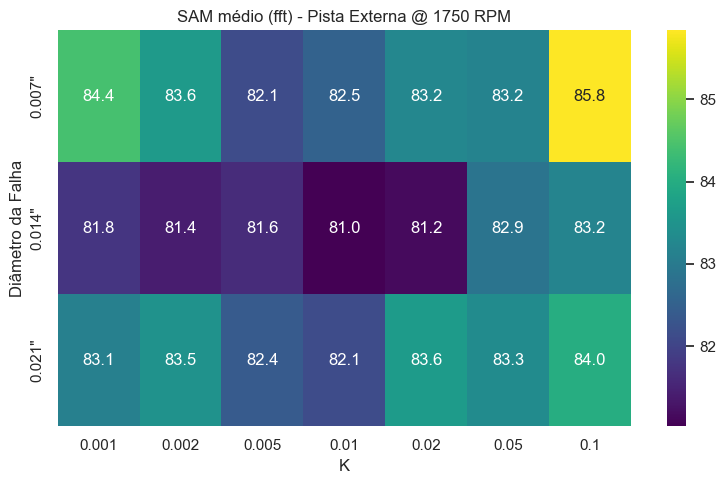

In [6]:
import seaborn as sns

# Garantir estilo
sns.set(style="whitegrid")

# Exemplo: heatmap para um RPM específico e um tipo de falha
rpm_plot = 1750
fault_plot = 'Pista Externa'
method_plot = 'fft'  # ou 'impulse'

subset = results_df[(results_df['rpm'] == rpm_plot) &
                    (results_df['fault_name'] == fault_plot) &
                    (results_df['method'] == method_plot)]

if subset.empty:
    print(f"Nenhum dado em results_df para RPM={rpm_plot}, falha='{fault_plot}', método='{method_plot}'.")
else:
    pivot = subset.pivot_table(index='diameter_label', columns='k', values='sam_mean_deg', aggfunc='mean')
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='viridis')
    plt.title(f'SAM médio ({method_plot}) - {fault_plot} @ {rpm_plot} RPM')
    plt.xlabel('K')
    plt.ylabel('Diâmetro da Falha')
    plt.tight_layout()
    plt.show()



Análise das melhores configurações (Menor SAM = Maior Similaridade com Real)



C:\Users\Cliente\AppData\Local\Temp\ipykernel_2244\161666163.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=best_5, x='sam_mean_deg', y='label', orient='h', palette='viridis')


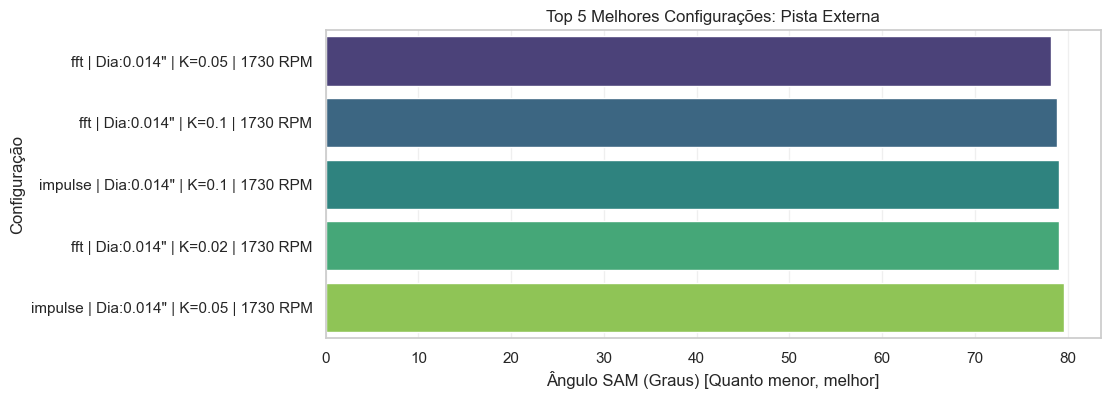

,rpm,diameter_label,method,k,sam_mean_deg,sam_std_deg
54,1730,"0.014""",fft,0.05,78.260826,1.989746
56,1730,"0.014""",fft,0.10,78.880729,2.256241
57,1730,"0.014""",impulse,0.10,79.095325,1.098753
52,1730,"0.014""",fft,0.02,79.110389,1.527621
55,1730,"0.014""",impulse,0.05,79.592201,1.010002


--------------------------------------------------------------------------------


C:\Users\Cliente\AppData\Local\Temp\ipykernel_2244\161666163.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=best_5, x='sam_mean_deg', y='label', orient='h', palette='viridis')


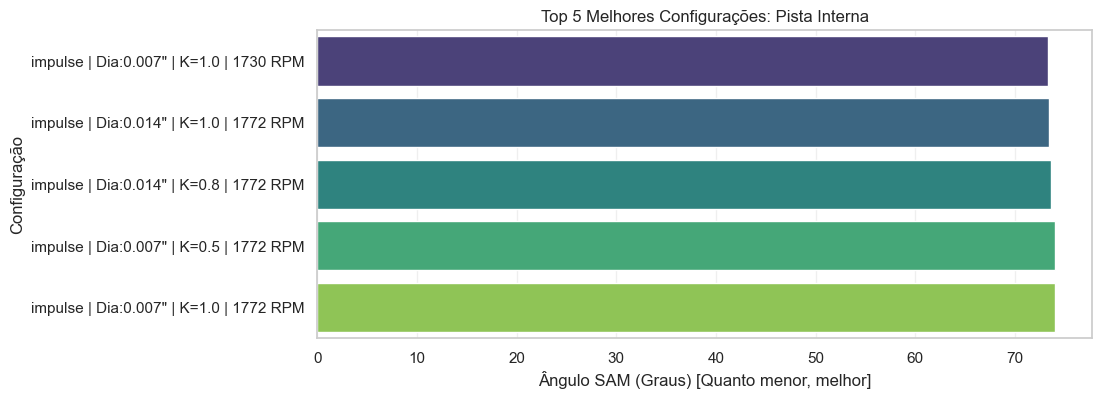

,rpm,diameter_label,method,k,sam_mean_deg,sam_std_deg
31,1730,"0.007""",impulse,1.0,73.328548,2.496965
427,1772,"0.014""",impulse,1.0,73.457603,1.057906
425,1772,"0.014""",impulse,0.8,73.660942,0.896845
379,1772,"0.007""",impulse,0.5,74.005057,3.685371
383,1772,"0.007""",impulse,1.0,74.068678,2.707495


C:\Users\Cliente\AppData\Local\Temp\ipykernel_2244\161666163.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=best_5, x='sam_mean_deg', y='label', orient='h', palette='viridis')


--------------------------------------------------------------------------------


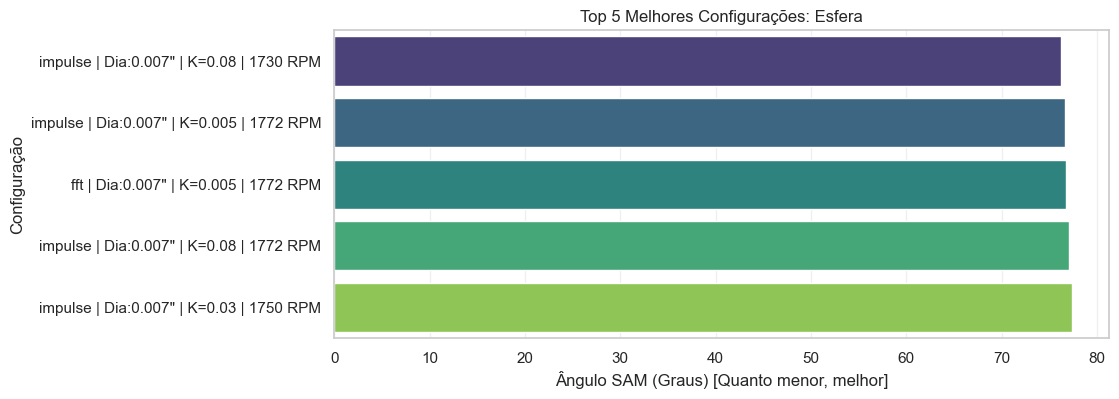

,rpm,diameter_label,method,k,sam_mean_deg,sam_std_deg
43,1730,"0.007""",impulse,0.080,76.274185,4.783158
385,1772,"0.007""",impulse,0.005,76.709477,4.568857
384,1772,"0.007""",fft,0.005,76.720049,4.572745
395,1772,"0.007""",impulse,0.080,77.099998,4.215301
215,1750,"0.007""",impulse,0.030,77.429188,5.090071


--------------------------------------------------------------------------------


In [7]:
# 5. Visualização das 5 Melhores Configurações por Falha (Menor SAM)

print("Análise das melhores configurações (Menor SAM = Maior Similaridade com Real)\n")

unique_faults = results_df['fault_name'].unique()

for fault in unique_faults:
    # Filtrar por defeito
    df_fault = results_df[results_df['fault_name'] == fault].copy()
    
    # Ordenar por SAM crescente (menor ângulo é melhor similaridade)
    df_fault = df_fault.dropna(subset=['sam_mean_deg'])
    best_5 = df_fault.sort_values(by='sam_mean_deg', ascending=True).head(5)
    
    if best_5.empty:
        print(f"Sem dados válidos para {fault}")
        continue
        
    # Plot
    plt.figure(figsize=(10, 4))
    
    # Criar um label descritivo para o eixo Y
    # Ex: "fft | 0.007" | K=0.1 | 1797 RPM"
    best_5['label'] = best_5.apply(
        lambda x: f"{x['method']} | Dia:{x['diameter_label']} | K={x['k']} | {x['rpm']} RPM", 
        axis=1
    )
    
    sns.barplot(data=best_5, x='sam_mean_deg', y='label', orient='h', palette='viridis')
    plt.xlabel('Ângulo SAM (Graus) [Quanto menor, melhor]')
    plt.ylabel('Configuração')
    plt.title(f'Top 5 Melhores Configurações: {fault}')
    plt.grid(True, axis='x', alpha=0.3)
    plt.show()
    
    # Mostrar tabela também
    display(best_5[['rpm', 'diameter_label', 'method', 'k', 'sam_mean_deg', 'sam_std_deg']])
    print("-" * 80)